In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample
from collections import defaultdict
from sklearn.covariance import MinCovDet
import scipy as sp
from scipy.stats import chi2
import copy
%matplotlib inline
sns.set_theme(style="darkgrid")

# Data set
---

In [2]:
df = pd.read_csv("../data_set/pokemon_alopez247.csv")
df = df[["Name", "Height_m", "Weight_kg", "Type_1",  "Body_Style"]]
df

,Name,Height_m,Weight_kg,Type_1,Body_Style
0,Bulbasaur,0.71,6.9,Grass,quadruped
1,Ivysaur,0.99,13.0,Grass,quadruped
2,Venusaur,2.01,100.0,Grass,quadruped
3,Charmander,0.61,8.5,Fire,bipedal_tailed
4,Charmeleon,1.09,19.0,Fire,bipedal_tailed
...,...,...,...,...,...
716,Yveltal,5.79,203.0,Dark,two_wings
717,Zygarde,5.00,305.0,Dragon,serpentine_body
718,Diancie,0.71,8.8,Rock,head_arms
719,Hoopa,0.51,9.0,Psychic,head_only


# Detecting Outlier
---

In [3]:
def robust_mahalanobis_method(df):
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [4]:
df_bivariate = df[["Weight_kg", "Height_m"]]
outliers, md = robust_mahalanobis_method(df=df_bivariate)
df_copy = copy.deepcopy(df_bivariate)
df_copy["md"] = md

def flag_outlier(df, outliers):
    flag = []
    for index in range(df.shape[0]):
        if index in outliers:
            flag.append(1)
        else:
            flag.append(0)
    return flag

df_copy["flag"] = flag_outlier(df_bivariate, outliers)
df = df[df_copy["flag"] == 0]

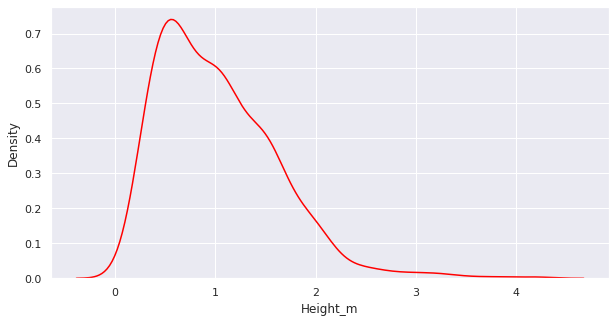

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax = sns.kdeplot(df["Height_m"], color="red")
plt.show()

In [6]:
s = df.mean(skipna=True, axis="index")
a=pd.DataFrame(s, columns=["Mean"]).T
pd.options.display.float_format = '{:.3f}'.format
print(a)


      Height_m  Weight_kg
Mean     1.026     46.974


# Bootstrap configuration
---
* ขนาดของ sample 1/4 ของ population
* สุ่ม 50 sample

In [7]:
#Configure bootstrap
n_iteration = 5
sample_ratio = 0.05
n_size = int(len(df) * sample_ratio)
CIs = [0.9, 0.95, 0.99]

# คำนวณ sample mean ของแต่ละ sample
---

In [8]:
def bootstrap():
    values = df["Height_m"].values
    means = list()
    for _ in range(n_iteration):
        sample = resample(values, n_samples=n_size, replace=True)
        x_bar = np.mean(sample)
        means.append(x_bar)
    return means

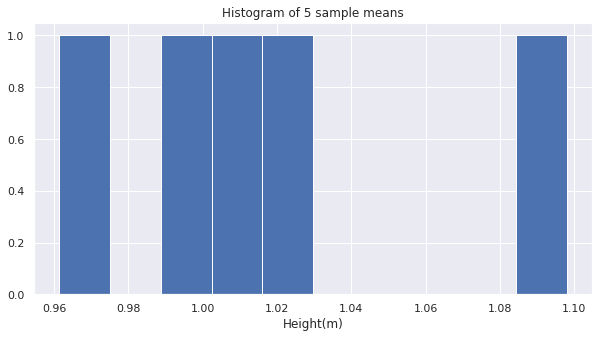

In [9]:
boot_means = bootstrap()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax.hist(boot_means)
ax.set(title=f"Histogram of {n_iteration} sample means", xlabel="Height(m)")
plt.show()

In [10]:
def confidence_interval(alpha: float, boot_means):
    p = ((1.0-alpha)/2.0) * 100
    lower =  np.percentile(boot_means, p) 
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper =  np.percentile(boot_means, p) 
    return (lower, upper)

Intervals = dict()
for alpha in CIs:
    lower, upper = confidence_interval(alpha, boot_means)
    Intervals[f"{alpha}"] = (lower, upper)
    print(f"\n{alpha*100}% Confidence level --> interval ({lower:.3f}, {upper:.3f})")
CL = pd.DataFrame(data=Intervals)


90.0% Confidence level --> interval (0.969, 1.084)

95.0% Confidence level --> interval (0.965, 1.091)

99.0% Confidence level --> interval (0.962, 1.097)


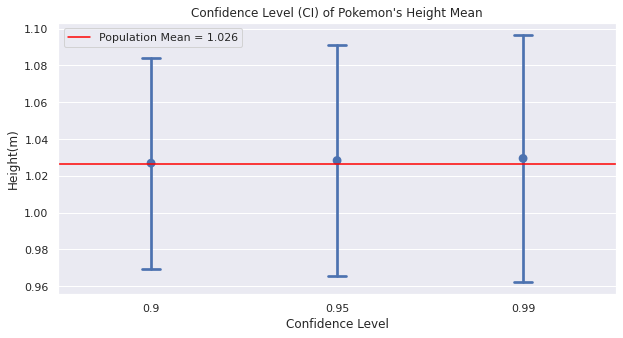

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax = sns.pointplot(data=CL, join=False, capsize=0.1)
ax.set(xlabel="Confidence Level", ylabel="Height(m)", title="Confidence Level (CI) of Pokemon's Height Mean")
red_line = ax.axhline(y=a["Height_m"].Mean,color="red")
legend = plt.legend([red_line], [f"Population Mean = {a['Height_m'].Mean:.3f}"], loc="upper left")
plt.show()

# Confidence interval configuration
---

In [12]:
n_interval = 50
CIs = [0.9, 0.95, 0.99, 0.3, 0.1]

In [13]:
conf_intervals = defaultdict(list)
for i in range(n_interval):
    boot_means = bootstrap()
    for alpha in CIs:
        lower, upper = confidence_interval(alpha, boot_means)
        conf_intervals[f"{alpha}"].append((lower, upper))

# Confidence Level 0.9
---

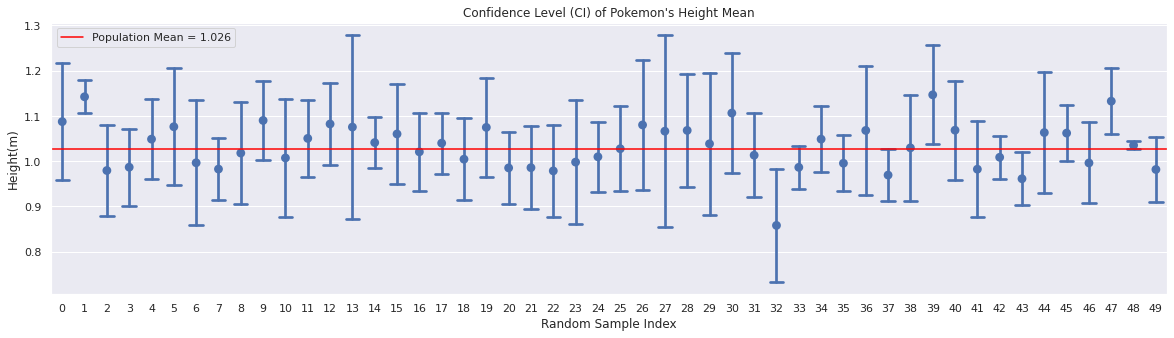

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 5))
ax = sns.pointplot(data=conf_intervals["0.9"], join=False, capsize=0.6)
ax.set(xlabel="Random Sample Index", ylabel="Height(m)", title="Confidence Level (CI) of Pokemon's Height Mean")
red_line = ax.axhline(y=a["Height_m"].Mean,color="red")
legend = plt.legend([red_line], [f"Population Mean = {a['Height_m'].Mean:.3f}"], loc="upper left")
plt.show()

# Confidence Level 0.95
---

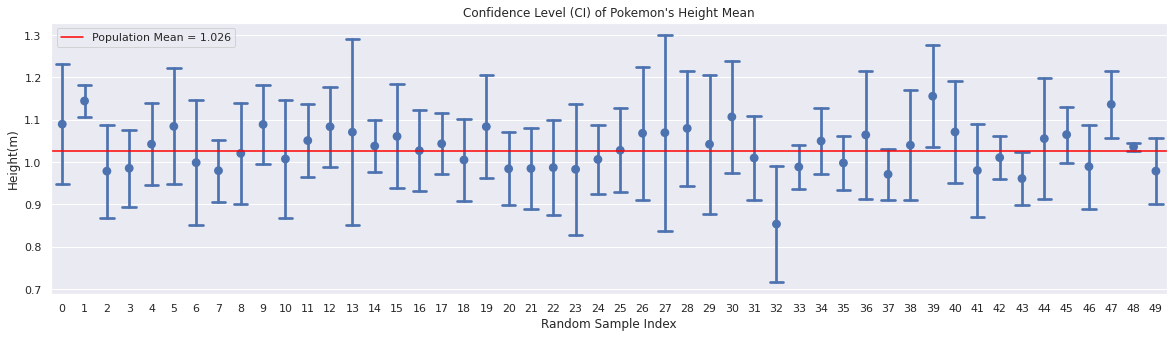

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 5))
ax = sns.pointplot(data=conf_intervals["0.95"], join=False, capsize=0.6)
ax.set(xlabel="Random Sample Index", ylabel="Height(m)", title="Confidence Level (CI) of Pokemon's Height Mean")
red_line = ax.axhline(y=a["Height_m"].Mean,color="red")
legend = plt.legend([red_line], [f"Population Mean = {a['Height_m'].Mean:.3f}"], loc="upper left")
plt.show()

# Confidence Level 0.99
---

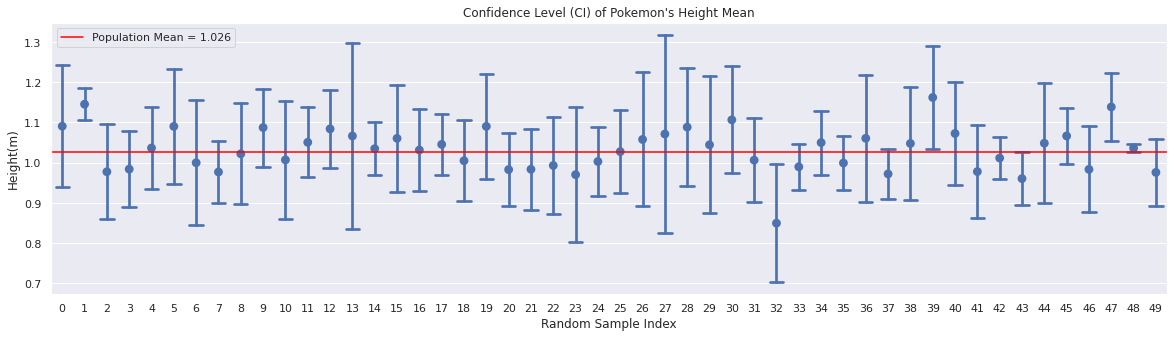

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 5))
ax = sns.pointplot(data=conf_intervals["0.99"], join=False, capsize=0.6)
ax.set(xlabel="Random Sample Index", ylabel="Height(m)", title="Confidence Level (CI) of Pokemon's Height Mean")
red_line = ax.axhline(y=a["Height_m"].Mean,color="red")
legend = plt.legend([red_line], [f"Population Mean = {a['Height_m'].Mean:.3f}"], loc="upper left")
plt.show()

# Confidence Level 0.3
---

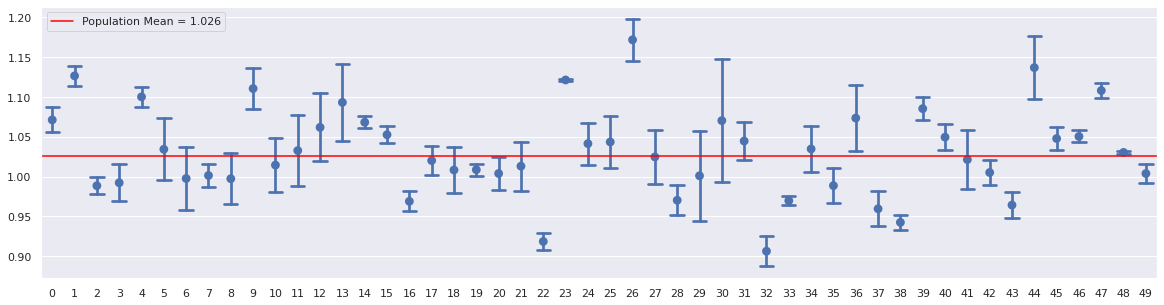

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 5))
ax = sns.pointplot(data=conf_intervals["0.3"], join=False, capsize=0.6)
red_line = ax.axhline(y=a["Height_m"].Mean,color="red")
legend = plt.legend([red_line], [f"Population Mean = {a['Height_m'].Mean:.3f}"], loc="upper left")
plt.show()

# Confidence Level 0.1
---

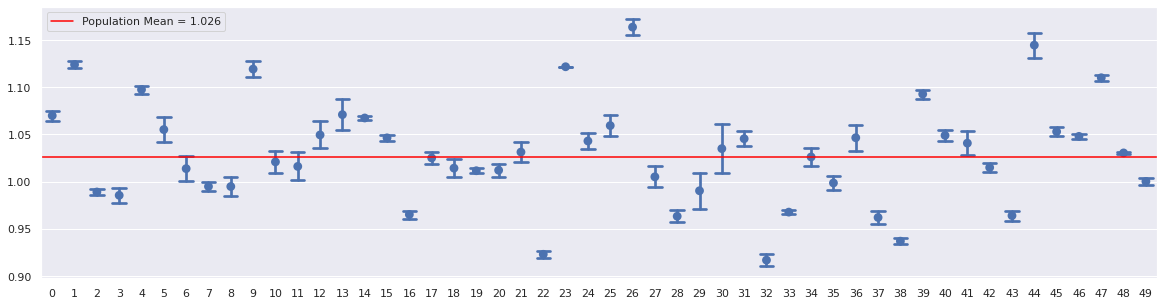

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 5))
ax = sns.pointplot(data=conf_intervals["0.1"], join=False, capsize=0.6)
red_line = ax.axhline(y=a["Height_m"].Mean,color="red")
legend = plt.legend([red_line], [f"Population Mean = {a['Height_m'].Mean:.3f}"], loc="upper left")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad0c918b-c6e2-4a56-985c-f4267acfa022' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>